C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


[Episode 0] Rewards: [3.9000022804055385], Collisions: [True], Distances: [683.392476336084], Epsilons: ['0.995']
[Episode 50] Rewards: [6.68214067002879], Collisions: [True], Distances: [501.2532592299171], Epsilons: ['0.774']
[Episode 100] Rewards: [6.700017316839889], Collisions: [True], Distances: [631.6741224513917], Epsilons: ['0.603']
[Episode 150] Rewards: [24.000000000001567], Collisions: [True], Distances: [1227.9442642512597], Epsilons: ['0.469']
[Episode 200] Rewards: [10.79354713760131], Collisions: [True], Distances: [647.1767943069086], Epsilons: ['0.365']
[Episode 250] Rewards: [18.65758293838863], Collisions: [True], Distances: [959.6119840636485], Epsilons: ['0.284']
[Episode 300] Rewards: [26.30758267310164], Collisions: [False], Distances: [1282.8885480712045], Epsilons: ['0.050']
[Episode 350] Rewards: [30.607582933180964], Collisions: [False], Distances: [1262.9999979397157], Epsilons: ['0.050']
[Episode 400] Rewards: [23.100131499752912], Collisions: [False], Dis

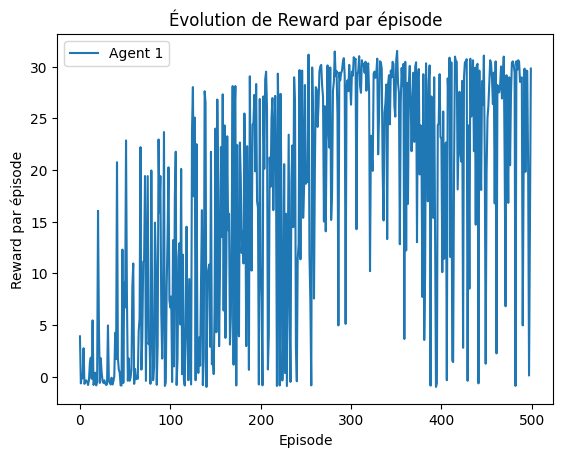

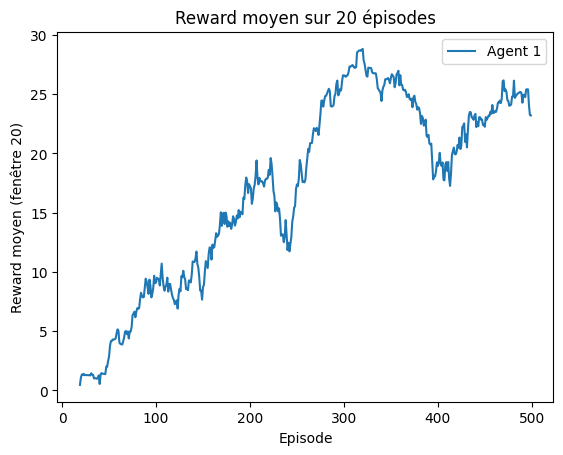

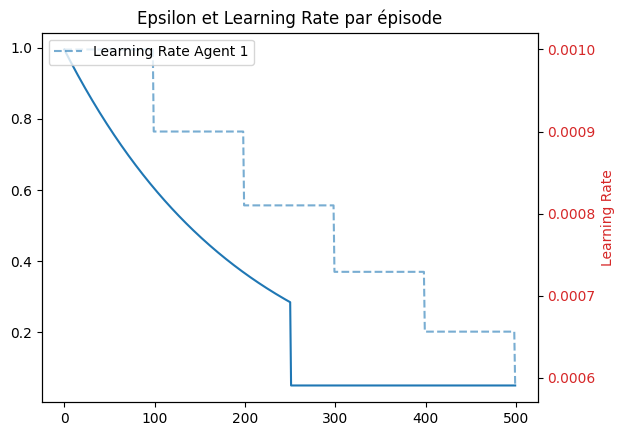

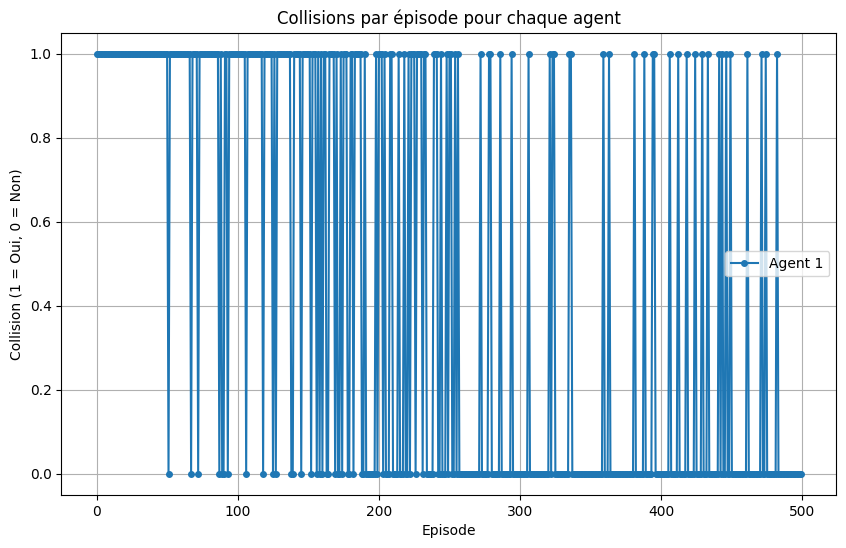

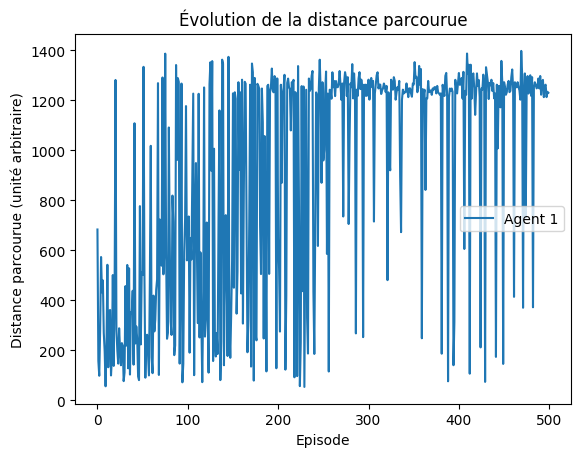

In [1]:
#!/usr/bin/env python3
"""
Multi-agent Double DQN sur l'environnement Highway-fast-v0 avec 2 véhicules contrôlés,
calculant explicitement un reward par agent sans utiliser de méthodes privées (_agent_rewards/_agent_reward).
"""

import gymnasium as gym
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import highway_env

# --------------------------------------------------------------------------
# 1) Chargement de la config de base (fichier fourni)
# --------------------------------------------------------------------------
config_path = "../config/1-highway-discrete-config.pkl"
with open(config_path, "rb") as f:
    base_config = pickle.load(f)

# --------------------------------------------------------------------------
# 2) Création et configuration de l'environnement multi-agent
# --------------------------------------------------------------------------
env = gym.make("highway-fast-v0", render_mode="human")
env.unwrapped.config.update(base_config)
env.unwrapped.config.update({
    "spawn_at_random": False,
    "controlled_vehicles": 1,
    "vehicles_count": 50,  # ajuste le trafic non contrôlé
    "action": {
        "type": "MultiAgentAction",
        "action_config": {"type": "DiscreteMetaAction"}
    },
    "observation": {
        "type": "MultiAgentObservation",
        "observation_config": {"type": "Kinematics"}
    },
    "scaling": 7.5,
    "centering_position": [0.5, 0.5],
    "render_agent": False
})
obs, info = env.reset(seed=0)

# --------------------------------------------------------------------------
# 3) Fonction de calcul de reward par agent
# --------------------------------------------------------------------------
def compute_agent_reward(veh, action):
    """
    Calcule pour un véhicule `veh` et action `action` un reward
    identique au comportement par défaut du env, sans utiliser d'APIs privées.
    """
    # 1) Reward de vitesse : linéaire entre reward_speed_range -> [0,1]
    v = float(veh.speed)
    vmin, vmax = base_config.get("reward_speed_range", [0, 1])
    if vmax > vmin:
        speed_score = np.clip((v - vmin) / (vmax - vmin), 0.0, 1.0)
    else:
        speed_score = 0.0
    r = speed_score * base_config.get("high_speed_reward", 0.0)

    # 2) Reward pour être sur la voie de droite
    #    lane_index[-1] donne l'indice de voie courant [0..lanes_count-1]
    lane_idx = veh.lane_index[-1]
    if lane_idx == base_config.get("lanes_count", 1) - 1:
        r += base_config.get("right_lane_reward", 0.0)

    # 3) Pénalité / bonus de changement de voie
    #    DiscreteMetaAction : 1=Left, 2=Right (selon mapping standard)
    if action in {1, 2}:
        r += base_config.get("lane_change_reward", 0.0)

    # 4) Pénalité de collision
    if getattr(veh, "crashed", False):
        r += base_config.get("collision_reward", 0.0)

    # 5) Pénalité hors-route (si activé en config)
    if getattr(veh, "off_road", False):
        r += base_config.get("offroad_terminal", 0.0)

    return r

# --------------------------------------------------------------------------
# 4) Définition du réseau et de l'agent Double DQN
# --------------------------------------------------------------------------
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.q_net      = DQN(state_dim, action_dim)
        self.target_net = DQN(state_dim, action_dim)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.optimizer  = torch.optim.Adam(self.q_net.parameters(), lr=1e-3)
        self.scheduler  = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=100, gamma=0.9)
        self.replay_buffer = deque(maxlen=100_000)
        self.gamma     = 0.99
        self.epsilon   = 1.0
        self.epsilon_min   = 0.05
        self.epsilon_decay = 0.995
        self.batch_size    = 64
        self.action_dim    = action_dim

    def get_action(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        with torch.no_grad():
            q_vals = self.q_net(torch.FloatTensor(state).unsqueeze(0)).squeeze(0).numpy()
        return int(np.argmax(q_vals))

    def update_epsilon(self, episode, total_episodes):
        if episode > total_episodes // 2:
            self.epsilon = self.epsilon_min
        else:
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))

        states_t      = torch.FloatTensor(states)
        actions_t     = torch.LongTensor(actions).unsqueeze(1)
        rewards_t     = torch.FloatTensor(rewards).unsqueeze(1)
        next_states_t = torch.FloatTensor(next_states)
        dones_t       = torch.FloatTensor(dones).unsqueeze(1)

        q_values      = self.q_net(states_t).gather(1, actions_t)
        with torch.no_grad():
            next_actions = self.q_net(next_states_t).argmax(dim=1, keepdim=True)
            q_next       = self.target_net(next_states_t).gather(1, next_actions)
            target       = rewards_t + self.gamma * (1 - dones_t) * q_next

        loss = F.mse_loss(q_values, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# --------------------------------------------------------------------------
# 5) Boucle d'entraînement multi-agent
# --------------------------------------------------------------------------


def train_multi_agents(agents, env, num_episodes=200, sync_target=10, collision_threshold=0.5):
    rewards_hist = {i: [] for i in range(len(agents))}
    eps_hist     = {i: [] for i in range(len(agents))}
    lr_hist      = {i: [] for i in range(len(agents))}

    # Variables pour les collisions et distances parcourues
    collisions_hist = {i: [] for i in range(len(agents))}
    distance_hist = {i: [] for i in range(len(agents))}

    for ep in range(num_episodes):
        obs, _ = env.reset()
        states = [o.flatten() for o in obs]
        ep_rewards = [0.0] * len(agents)
        ep_collisions = [False] * len(agents)  # Initialisation des collisions par agent
        ep_distances = [0.0] * len(agents)  # compteur de distance parcourue
        done = False
        step = 0
        prev_positions = [np.array(veh.position) for veh in env.unwrapped.controlled_vehicles]  # positions initiales

        while not done:
            # 1) Choix des actions
            actions = [agent.get_action(s) for agent, s in zip(agents, states)]
            # 2) Step
            next_obs, _, term, trunc, _ = env.step(tuple(actions))
            done = term or trunc

            # 3) Calcul des rewards par agent
            rewards = [
                compute_agent_reward(env.unwrapped.controlled_vehicles[i], actions[i])
                for i in range(len(agents))
            ]

            # 4) Détection des collisions pour chaque agent
            for i, veh in enumerate(env.unwrapped.controlled_vehicles):
                if getattr(veh, "crashed", False):  # Si un véhicule a eu une collision
                    ep_collisions[i] = True  # Marque l'agent comme ayant eu une collision

            # 5) Calcul de la distance parcourue pour chaque agent
            for i, veh in enumerate(env.unwrapped.controlled_vehicles):
                prev_pos = prev_positions[i]
                curr_pos = np.array(veh.position)  # mise à jour de la position actuelle
                distance = np.linalg.norm(curr_pos - prev_pos)
                ep_distances[i] += distance

            # 6) Stockage et update
            next_states = [no.flatten() for no in next_obs]
            for i, agent in enumerate(agents):
                agent.replay_buffer.append((
                    states[i], actions[i], rewards[i],
                    next_states[i], float(done)
                ))
                agent.update()
                ep_rewards[i] += rewards[i]

            states = next_states
            prev_positions = [np.array(veh.position) for veh in env.unwrapped.controlled_vehicles]  # mise à jour des positions
            step += 1

        # 7) Fin d’épisode : epsilon, lr, historiques, sync target
        for i, agent in enumerate(agents):
            agent.update_epsilon(ep, num_episodes)
            agent.scheduler.step()
            rewards_hist[i].append(ep_rewards[i])
            eps_hist[i].append(agent.epsilon)
            lr_hist[i].append(agent.optimizer.param_groups[0]['lr'])
            collisions_hist[i].append(1 if ep_collisions[i] else 0)  # 1 si collision, sinon 0
            distance_hist[i].append(ep_distances[i])

        if ep % sync_target == 0:
            for agent in agents:
                agent.target_net.load_state_dict(agent.q_net.state_dict())

        if ep % 50 == 0:
            eps_str = [f"{a.epsilon:.3f}" for a in agents]
            print(f"[Episode {ep}] Rewards: {ep_rewards}, Collisions: {ep_collisions}, Distances: {ep_distances}, Epsilons: {eps_str}")

    return rewards_hist, eps_hist, lr_hist, collisions_hist, distance_hist



# --------------------------------------------------------------------------
# 6) Visualisation
# --------------------------------------------------------------------------
def plot_agent_metrics(hist, label):
    plt.figure()
    for i, vals in hist.items():
        plt.plot(vals, label=f"Agent {i+1}")
    plt.xlabel("Episode")
    plt.ylabel(label)
    plt.legend()
    plt.title(f"Évolution de {label}")
    plt.show()

def plot_metrics_on_same_graph(hist1, hist2, label1, label2):
    """
    Affiche deux courbes sur le même graphique en prenant en compte des échelles différentes.
    """
    plt.figure()
    
    # Plot de la première métrique (epsilon)
    for i, vals in hist1.items():
        plt.plot(vals, label=f"{label1} Agent {i+1}")
    
    # Création d'un axe secondaire pour le learning rate
    ax2 = plt.gca().twinx()
    
    # Plot de la deuxième métrique (learning rate)
    for i, vals in hist2.items():
        ax2.plot(vals, '--', label=f"{label2} Agent {i+1}", alpha=0.6)
    
    plt.xlabel("Episode")
    plt.ylabel(label1)
    ax2.set_ylabel(label2, color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Légende
    plt.legend(loc="upper left")
    plt.title(f"{label1} et {label2} par épisode")
    plt.show()

# Affichage des collisions
def plot_collisions(collisions_hist):
    plt.figure()
    for i, vals in collisions_hist.items():
        plt.plot(vals, label=f"Agent {i+1}")
    plt.xlabel("Episode")
    plt.ylabel("Nombre de collisions")
    plt.legend()
    plt.title("Évolution des collisions")
    plt.show()

# Affichage des distances parcourues
def plot_distances(distance_hist):
    plt.figure()
    for i, vals in distance_hist.items():
        plt.plot(vals, label=f"Agent {i+1}")
    plt.xlabel("Episode")
    plt.ylabel("Distance parcourue (unité arbitraire)")
    plt.legend()
    plt.title("Évolution de la distance parcourue")
    plt.show()

def plot_collisions(collisions_hist):
    """
    Affiche un histogramme indiquant si une collision a eu lieu à chaque épisode pour chaque agent.
    1 pour une collision, 0 pour aucune collision.
    """
    plt.figure(figsize=(10, 6))

    for i, collisions in collisions_hist.items():
        plt.plot(collisions, label=f"Agent {i+1}", marker='o', linestyle='-', markersize=4)
    
    plt.xlabel("Episode")
    plt.ylabel("Collision (1 = Oui, 0 = Non)")
    plt.title("Collisions par épisode pour chaque agent")
    plt.legend()
    plt.grid(True)
    plt.show()
# --------------------------------------------------------------------------
# 7) Exécution principale
# --------------------------------------------------------------------------
if __name__ == "__main__":
    # Dimensions
    obs, _ = env.reset()
    state_dim      = obs[0].flatten().shape[0]
    action_spaces  = env.action_space.spaces
    action_dims    = [space.n for space in action_spaces]

    # Création des agents
    agents = [DQNAgent(state_dim, ad) for ad in action_dims]

    # Entraînement
    rewards_hist, eps_hist, lr_hist, collisions_hist, distance_hist = train_multi_agents(
        agents,
        env,
        num_episodes=500,
        sync_target=10
    )

    # Affichage des métriques
    plot_agent_metrics(rewards_hist, "Reward par épisode")
    # Moyenne mobile (fenêtre 20)
    plt.figure()
    window = 20
    for i, r in rewards_hist.items():
        mov = np.convolve(r, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(r)), mov, label=f"Agent {i+1}")
    plt.xlabel("Episode")
    plt.ylabel(f"Reward moyen (fenêtre {window})")
    plt.legend()
    plt.title("Reward moyen sur 20 épisodes")
    plt.show()

    plot_metrics_on_same_graph(eps_hist, lr_hist, "Epsilon", "Learning Rate")
    plot_collisions(collisions_hist)
    plot_distances(distance_hist)
